# Intro

## Background Problem

NASA has been lauched numerous satellites into the space to observe earth surfaces.    
These satellites has been taking countless of pictures within these 4 categories (cloudy area, desert, green area, and water)

Apparently, NASA's Earth Science Division is struggling to classify these images manually. To speed up this process, they ask the data division to build a robust classifier model to `classify images of cloudy area, desert, green area, and water.` Since `all of these categories are equally important`, they want the model to be able to generate `minimum accuracy of 90%.`

This project is projected to speed up the image classification task by 70%.

### Consideration

The division has images within these 4 categories and they already labeled. Thus, This project will be used to build a supervised deep learning model for the image classification task

There are 5,631 images in the dataset that belong to 4 categories/classes

## Objective

To speed up NASA's Earth Science Division's task of classifying images of cloudy area, desert, green area, and water that taken from satellites, I will build a supervised deep learning model to classify them. 

This project can be done by analyzing dataset given by the team. The model must be able to achieve minimum accuracy of 90%. This project must be finished within 6 months.

# Import Libs

In [1]:
import os
from os.path import join as path_join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import DataFrameIterator

from sklearn.metrics import accuracy_score

import json

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
# define dir const
IMG_DIR_PATH = "/kaggle/input/satellite-image-classification/data"

In [3]:
# define image class list
img_classes = [dirname for dirname in os.listdir(IMG_DIR_PATH)]
img_classes

['cloudy', 'desert', 'green_area', 'water']

In [4]:
# define image examples to plot
img_examples_dict = {}

for img_class in img_classes:
    img_file_path = []

    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class))[:5]:
        img_file_path.append(
            path_join(IMG_DIR_PATH, img_class, img_file_name)
        )
        
    img_examples_dict[img_class] = img_file_path

In [5]:
img_examples_dict

{'cloudy': ['/kaggle/input/satellite-image-classification/data/cloudy/train_17406.jpg',
  '/kaggle/input/satellite-image-classification/data/cloudy/train_28684.jpg',
  '/kaggle/input/satellite-image-classification/data/cloudy/train_33597.jpg',
  '/kaggle/input/satellite-image-classification/data/cloudy/train_34079.jpg',
  '/kaggle/input/satellite-image-classification/data/cloudy/train_30586.jpg'],
 'desert': ['/kaggle/input/satellite-image-classification/data/desert/desert(14).jpg',
  '/kaggle/input/satellite-image-classification/data/desert/desert(217).jpg',
  '/kaggle/input/satellite-image-classification/data/desert/desert(204).jpg',
  '/kaggle/input/satellite-image-classification/data/desert/desert(1030).jpg',
  '/kaggle/input/satellite-image-classification/data/desert/desert(1080).jpg'],
 'green_area': ['/kaggle/input/satellite-image-classification/data/green_area/Forest_2838.jpg',
  '/kaggle/input/satellite-image-classification/data/green_area/Forest_205.jpg',
  '/kaggle/input/sat

In [6]:
def read_img_bgr(img_file_path: str):
    """
    Read image using cv2 using bgr channel
    
    :param img_file_path (str) -> image file path to load
    :return numpy array of image with 3 channel dimensions bgr
    """
    # return image bgr
    return cv2.imread(img_file_path, cv2.IMREAD_COLOR)

In [7]:
def convert_img_channel(img_loaded: object, parser: int):
    """
    Convert :img_loaded from bgr into other channel
    parser_list: https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html
    
    :img_loaded -> loaded image with channel bgr
    :parser -> code to parse channel
    
    :return converted color to desired channel of :loaded_image
    """
    return cv2.cvtColor(img_loaded, parser)

In [8]:
def show_subplot_img(
    ncols: int, 
    figsize: tuple, 
    imgs_dict: dict, 
    nrows: int=1,
    cmap="viridis",
    is_plot_rgb=False,
    rgb_label=["r", "g", "b"]
)->None:
    """
    Create subplot to plot image
    
    :param ncols (int) -> number of subplot's column(s)
    :param figsize (tuple) -> subplot's figure size
    :param imgs_dict (dict) -> ...
    :param nrows (int, default=1) -> number of subplot's row(s)
    :param cmap (str, default=viridis [src: matplotlib's doc]) -> matplotlib's color map
    :param is_plot_rgb (bool) -> whether the plot used to plot each rgb color channel
    :param rgb_label (list, default=["r", "g", "b"]) -> list of color channel title
    
    :return None
    """

    for i, (img_class, img_dict) in enumerate(imgs_dict.items()):
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

        for j, img in enumerate(img_dict):
            axs[j].imshow(img, cmap)
            if(not is_plot_rgb):
                axs[j].title.set_text(f"image {j+1}")
            else:
                axs[j].title.set_text(f"channel {rgb_label[j]}")

        fig.suptitle(img_class)
    plt.show()

In [9]:
# I found out that images in dataset are having different size
# In this cell I do comprehensive analysis to find out 
# how many type of image sizes appear in the dataset

img_shape_64_64 = {}
img_shape_256_256 = {}
img_shape_else = []

for img_class in img_classes:
    img_64_64 = []
    img_256_256 = []
    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        img_read = read_img_bgr(path_join(IMG_DIR_PATH, img_class, img_file_name))
        if(img_read.shape==(64,64,3)):
            img_64_64.append(img_file_name)
        elif(img_read.shape==(256,256,3)):
            img_256_256.append(img_file_name)
        else:
            img_shape_else.append([img_read.shape, img_file_name])
    img_shape_64_64[img_class] = img_64_64
    img_shape_256_256[img_class] = img_256_256

print("image shape 64x64")
for k, v in img_shape_64_64.items():
    print(f"{k}: {len(v)}")

print("\nimage shape 256x256")
for k, v in img_shape_256_256.items():
    print(f"{k}: {len(v)}")

print("\nother shape: ", len(img_shape_else))

image shape 64x64
cloudy: 0
desert: 0
green_area: 1500
water: 1500

image shape 256x256
cloudy: 1500
desert: 1131
green_area: 0
water: 0

other shape:  0


In [10]:
# read 2 rgb images as example

IMG_RGB_EXAMPLE1 = convert_img_channel( 
    read_img_bgr(path_join(IMG_DIR_PATH, "green_area/Forest_344.jpg")),
    cv2.COLOR_BGR2RGB
)

IMG_RGB_EXAMPLE2 = convert_img_channel( 
    read_img_bgr(path_join(IMG_DIR_PATH, "cloudy/train_33597.jpg")),
    cv2.COLOR_BGR2RGB
)

In [11]:
# print size of example images
print("ex img1 shape: ", IMG_RGB_EXAMPLE1.shape)
print("ex img2 shape: ", IMG_RGB_EXAMPLE2.shape)

ex img1 shape:  (64, 64, 3)
ex img2 shape:  (256, 256, 3)


- The in-depth analysis shows that the dataset contains 2 types of images in terms of size, such as 64x64x3 and 256x256x3.
- Since deep learning model requires images in the same size, thus I will use image size of 128x128x3 because it's a balanced choice that halves 256 and doubles 64

## EDA

In [12]:
# defined image shapes with and without channel
IMG_SHAPE = (128, 128)
IMG_SHAPE_WITH_CHANNEL = (128, 128, 3)

In [13]:
# read all images and store into dict
img_rgbs_dict={}
for k, img_file_paths in img_examples_dict.items():
    img_read = []
    for img_file_path in img_file_paths:
        img_read.append(
            convert_img_channel(
                read_img_bgr(img_file_path),
                cv2.COLOR_BGR2RGB
            )
        )
    img_rgbs_dict[k] = img_read

In [14]:
img_rgbs_dict["cloudy"][0]

array([[[168, 177, 173],
        [168, 177, 173],
        [168, 177, 173],
        ...,
        [168, 181, 173],
        [170, 181, 175],
        [171, 181, 176]],

       [[168, 177, 173],
        [168, 177, 173],
        [168, 177, 173],
        ...,
        [170, 181, 173],
        [172, 181, 175],
        [173, 181, 175]],

       [[168, 177, 174],
        [168, 177, 174],
        [168, 177, 173],
        ...,
        [172, 181, 174],
        [173, 181, 174],
        [175, 181, 175]],

       ...,

       [[169, 177, 172],
        [169, 177, 173],
        [169, 177, 173],
        ...,
        [172, 181, 174],
        [172, 181, 174],
        [172, 181, 174]],

       [[169, 177, 172],
        [169, 177, 173],
        [169, 177, 173],
        ...,
        [172, 181, 174],
        [172, 181, 174],
        [172, 181, 174]],

       [[169, 177, 172],
        [169, 177, 173],
        [169, 177, 173],
        ...,
        [172, 181, 174],
        [172, 181, 174],
        [172, 181, 174]]

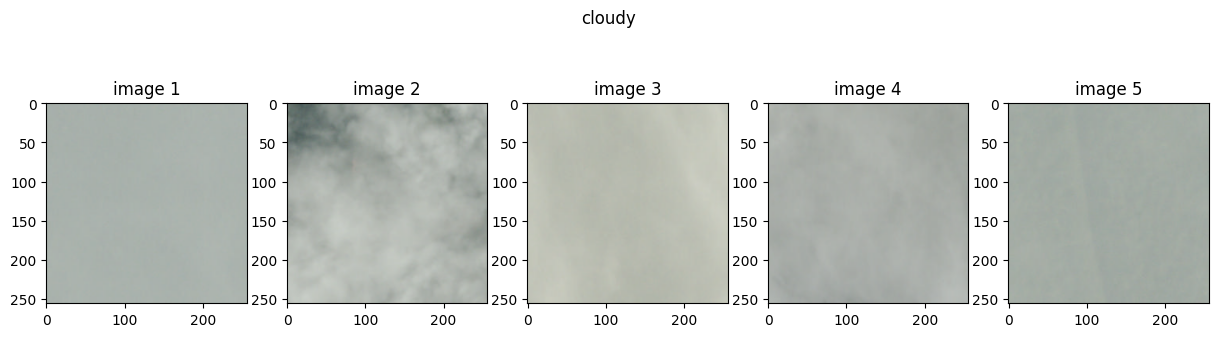

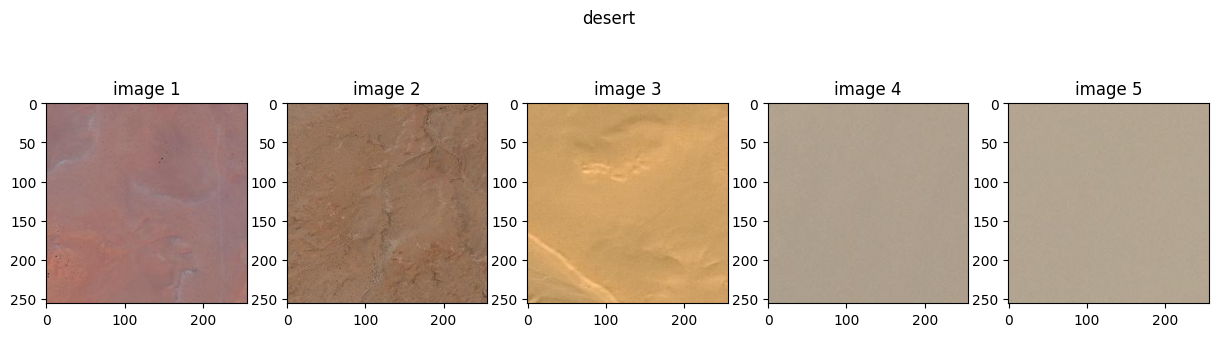

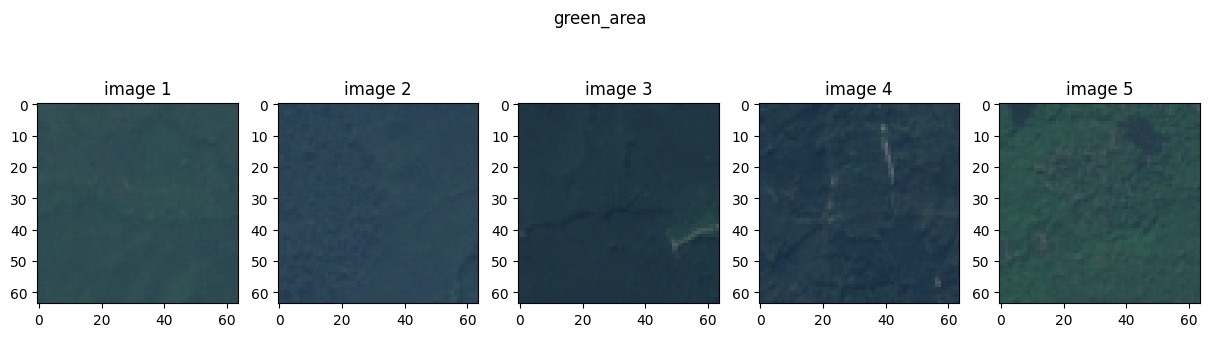

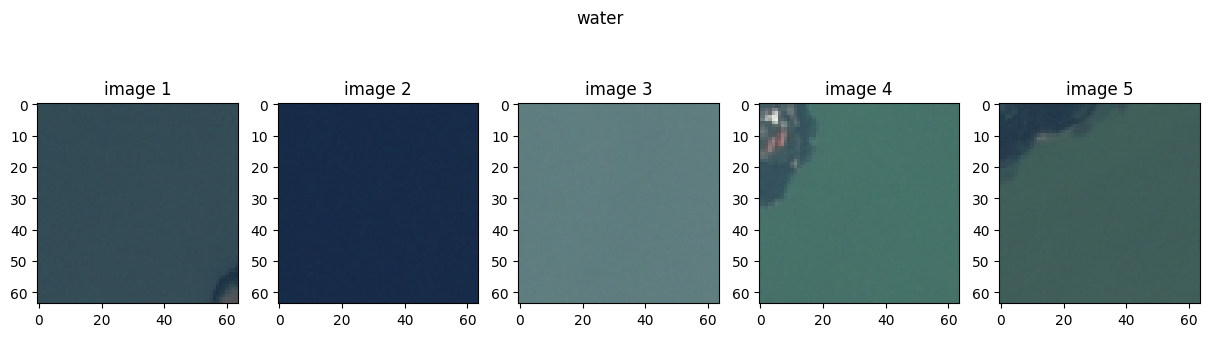

In [15]:
# plot 5 image for each class
show_subplot_img(5, (15, 4), img_rgbs_dict)

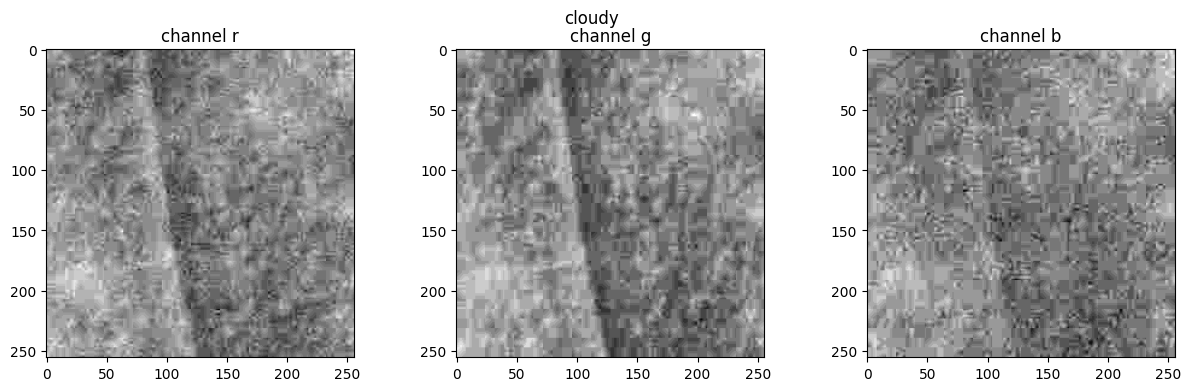

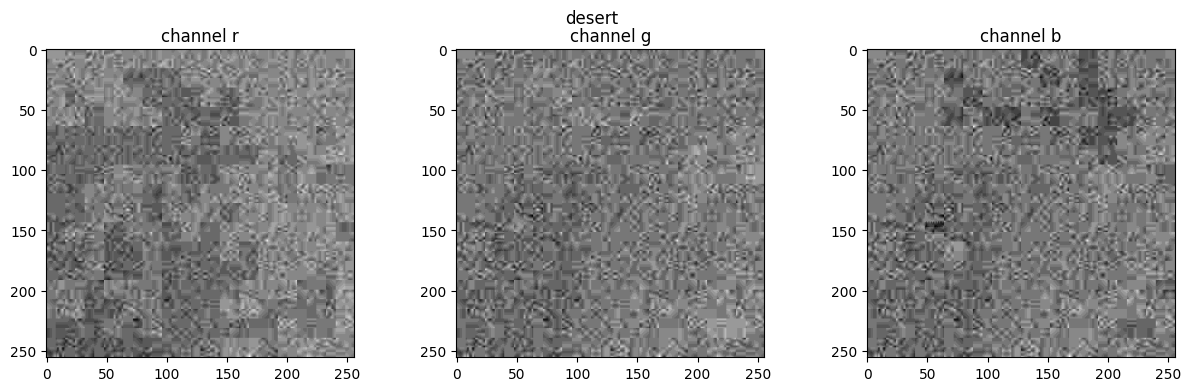

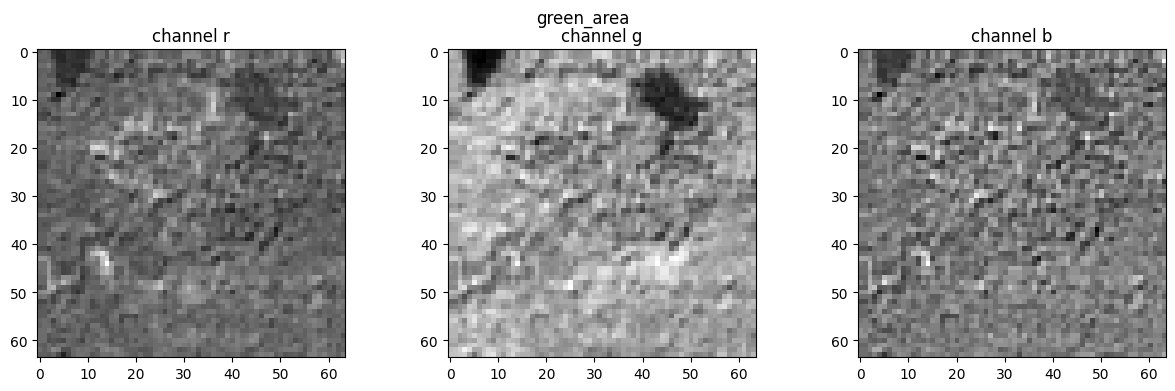

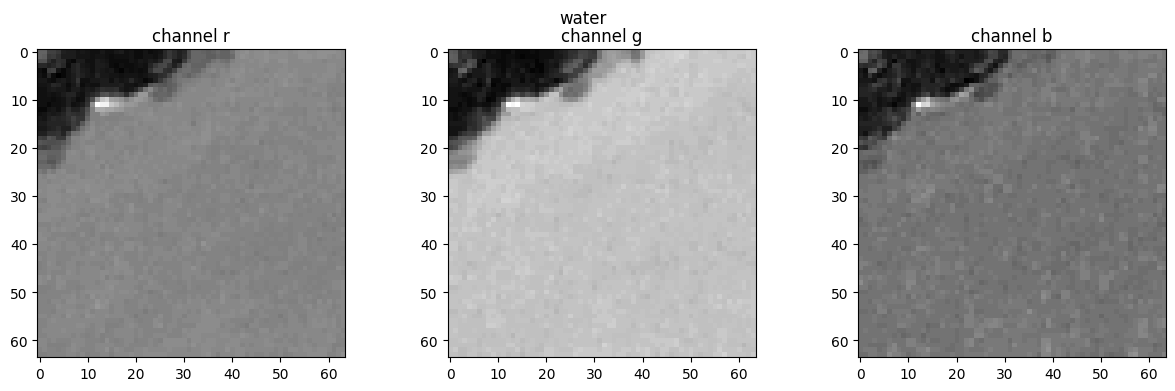

In [16]:
# plot rgb for each img class on 5th image
for img_class, img_rgbs in img_rgbs_dict.items():

    # split each color channel of an image
    r,g,b = cv2.split(img_rgbs[4])
    img_wrapper_dict = {img_class: [r,g,b]}
    
    show_subplot_img(3, (15, 4), img_wrapper_dict, cmap="gray", is_plot_rgb=True)

- The visualizations above show that if I split example image based on its color channel (rgb), green area and cloudy images are look pretty simmilar.
- But, when it comes to colors, it's easier to differentiate these images
    - Cloudy area: gray
    - Dessert: somewhat brown
    - Green area: mixture of blue and green with contours that spread into all area
    - Water: mixture of blue and green that might be contains objects

- Based on my analysis, these images can be distinguished by image's contents and colors. `Thus, I will use rbg image color to train the model`

# Feature Engineering

In this project, I will do some image augmentations to add variability on train and validation data, such as:
- Illumination or brightness
- Contrast

Hopefully these image augmentations will help the model to understand each class's characteristics better, thus increase the overall accuracy.

## Illuminate

In [17]:
# define matrix to adjust image's brightness
matrix_bright = np.ones(IMG_RGB_EXAMPLE2.shape, dtype="uint8") * 50

In [18]:
# brighten an image
img_rgb_brighter = cv2.add(
    IMG_RGB_EXAMPLE2,
    matrix_bright
)

# darken an image
img_rgb_darker = cv2.subtract(
    IMG_RGB_EXAMPLE2, 
    matrix_bright
)

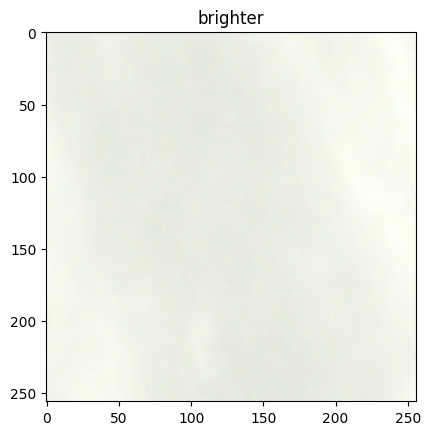

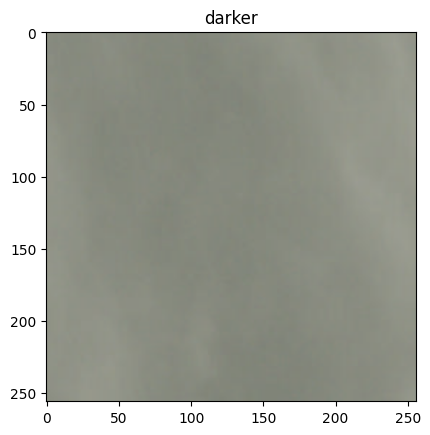

In [19]:
# plot adjusted brigthness image
plt.imshow(img_rgb_brighter)
plt.title("brighter")
plt.show()

plt.imshow(img_rgb_darker)
plt.title("darker")
plt.show()

## Contrast

In [20]:
# define matrix for increasing and decreasing contrast
matrix_contrast_up = np.ones(IMG_RGB_EXAMPLE2.shape) * 1.6
matrix_contrast_down = np.ones(IMG_RGB_EXAMPLE2.shape) * 0.4

In [21]:
# adjust images' contrasts
img_rgb_cont_up   = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_up
    )
)

img_rgb_brighter_cont_up = np.uint8(
    cv2.multiply(
        np.float64(img_rgb_brighter), 
        matrix_contrast_up)
    )

img_rgb_cont_down = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_down
    )
)

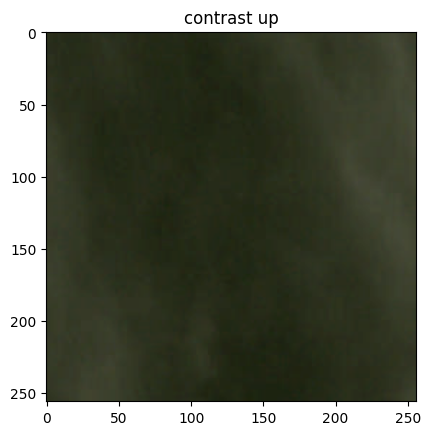

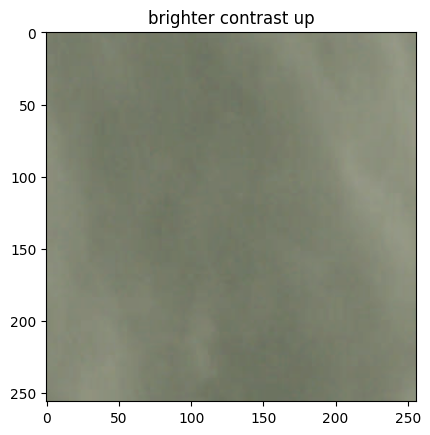

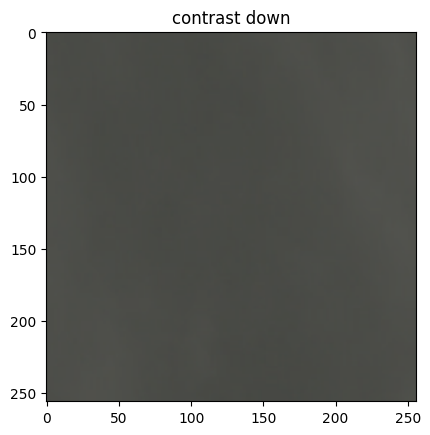

In [22]:
# plot adjusted contrast images
plt.imshow(img_rgb_cont_up)
plt.title("contrast up")
plt.show()

plt.imshow(img_rgb_brighter_cont_up)
plt.title("brighter contrast up")
plt.show()

plt.imshow(img_rgb_cont_down)
plt.title("contrast down")
plt.show()

In [23]:
# provide list of labels and image paths to create dataframe
labels = [] 
paths = []

for img_class in img_classes:
    for file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        labels.append(img_class)
        paths.append(path_join(IMG_DIR_PATH, img_class, file_name))

In [24]:
print(labels[:5])
print(labels[-5:])

['cloudy', 'cloudy', 'cloudy', 'cloudy', 'cloudy']
['water', 'water', 'water', 'water', 'water']


In [25]:
print(paths[:5])
print(paths[-5:])

['/kaggle/input/satellite-image-classification/data/cloudy/train_17406.jpg', '/kaggle/input/satellite-image-classification/data/cloudy/train_28684.jpg', '/kaggle/input/satellite-image-classification/data/cloudy/train_33597.jpg', '/kaggle/input/satellite-image-classification/data/cloudy/train_34079.jpg', '/kaggle/input/satellite-image-classification/data/cloudy/train_30586.jpg']
['/kaggle/input/satellite-image-classification/data/water/SeaLake_682.jpg', '/kaggle/input/satellite-image-classification/data/water/SeaLake_1614.jpg', '/kaggle/input/satellite-image-classification/data/water/SeaLake_1184.jpg', '/kaggle/input/satellite-image-classification/data/water/SeaLake_1427.jpg', '/kaggle/input/satellite-image-classification/data/water/SeaLake_2146.jpg']


In [26]:
# create dataframe contains label and image path
img_df = pd.DataFrame(
    data={
        "label": labels,
        "path": paths
    }
)

img_df

,label,path
0,cloudy,/kaggle/input/satellite-image-classification/d...
1,cloudy,/kaggle/input/satellite-image-classification/d...
2,cloudy,/kaggle/input/satellite-image-classification/d...
3,cloudy,/kaggle/input/satellite-image-classification/d...
4,cloudy,/kaggle/input/satellite-image-classification/d...
...,...,...
5626,water,/kaggle/input/satellite-image-classification/d...
5627,water,/kaggle/input/satellite-image-classification/d...
5628,water,/kaggle/input/satellite-image-classification/d...
5629,water,/kaggle/input/satellite-image-classification/d...


In [27]:
def get_index_sample_without_replace(
    df: pd.DataFrame, 
    sample_size: int
):
    """
    Get index of :sample_size sample data without replacement from :df
    
    :param df (pd.DataFrame) -> data source
    :param sample_size (int) -> number of samples to return from :df
    
    :return index of samples
    """
    
    return list(
        df.sample(
            n=sample_size,
            replace=False,
            random_state=0
        ).index
    )

In [28]:
img_df["label"].unique()

array(['cloudy', 'desert', 'green_area', 'water'], dtype=object)

In [29]:
# define dict to contains number of samples of ecach image class
# used for test set
test_sizes_dict = {}

for img_class in img_df["label"].unique():
    # sample 0.1
    test_sizes_dict[img_class] = int(0.05 * img_df[img_df["label"]==img_class].shape[0])
    
test_sizes_dict

{'cloudy': 75, 'desert': 56, 'green_area': 75, 'water': 75}

In [30]:
# define list to hold index of images for test set
test_data_idx = []
for img_class, sample_size in test_sizes_dict.items():
    test_data_idx+=get_index_sample_without_replace(
        img_df[img_df["label"]==img_class], 
        sample_size
    )

In [31]:
len(test_data_idx)

281

> All test data indexes are unique

In [32]:
# split dataset into 2: test & train-val
img_test_df = img_df.iloc[test_data_idx]
img_train_val_df = img_df.drop(index=test_data_idx)

In [33]:
img_train_val_df["label"].value_counts(normalize=True)

label
cloudy        0.266355
green_area    0.266355
water         0.266355
desert        0.200935
Name: proportion, dtype: float64

In [34]:
img_test_df["label"].value_counts(normalize=True)

label
cloudy        0.266904
green_area    0.266904
water         0.266904
desert        0.199288
Name: proportion, dtype: float64

In [35]:
# print shape, num of rows with missing and duplicated values
# on all image generators
for (label, df) in zip(
    ["img train-val generator", "img test generator"], 
    [img_train_val_df, img_test_df]
):
    print(label)
    print("shape: ", df.shape)
    print("number of rows with missing value: ", df.isna().sum().sum())
    print("number of rows with duplicated value: ", df.duplicated().sum(), end="\n\n")

img train-val generator
shape:  (5350, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0

img test generator
shape:  (281, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0



## Image Generator

In this step I will adding more variance on images for training and validation. This step will make sure that the model will learn wide range of image's characteristics.
The augmentation that I will do are:
- horizontal & vertical flip
- zoom range 1 to 1,5
- rescale 1/255 -> rescaling to decrease the image's pixels while still retaining the same information can make the training process faster
- batch processing -> improve training speed and generalizability

In [36]:
# define parameters for img data generator
rescale = 1./255
horizontal_flip = vertical_flip = True
zoom_range = [1, 1.5]
batch_size=64

In [37]:
# create image data generator for train-val images
# I will use 15% of images for validation
train_val_img_datagen = ImageDataGenerator(
    validation_split=0.15,
    rescale=rescale,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip,
    zoom_range=zoom_range
)

In [38]:
# create image data generator for test images
test_img_datagen = ImageDataGenerator(rescale=rescale)

In [39]:
def adjust_img_contrast(img: object) -> object:
    """
    Adjust :img contrast using range contrast value from 0.4 to 1.6
    
    :param img (object) -> The image that needs contrast adjustment
    
    :return image with new contrast (object)
    """
    return tf.image.random_contrast(
        img, 
        lower=0.4, 
        upper=1.6, 
        seed=9
    )

In [40]:
# split train-val images
img_train = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="training",
    shuffle=True,
    batch_size=batch_size,
    preprocessing_function=adjust_img_contrast,
    color_mode="rgb"
)

img_val = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="validation",
    shuffle=True, 
    batch_size=batch_size,
    preprocessing_function=adjust_img_contrast,
    color_mode="rgb"
)

Found 4548 validated image filenames belonging to 4 classes.
Found 802 validated image filenames belonging to 4 classes.


In [41]:
# plot some augmented images
img_gen_rgbs_dict = {}
img_pos = 0
for i, batch_name in enumerate(img_train.class_indices):
    img_gen_rgbs = []
    for j in range(5):
        img_gen_rgbs.append(img_train[0][0][img_pos])

    img_gen_rgbs_dict[batch_name] = img_gen_rgbs
    img_pos+=5

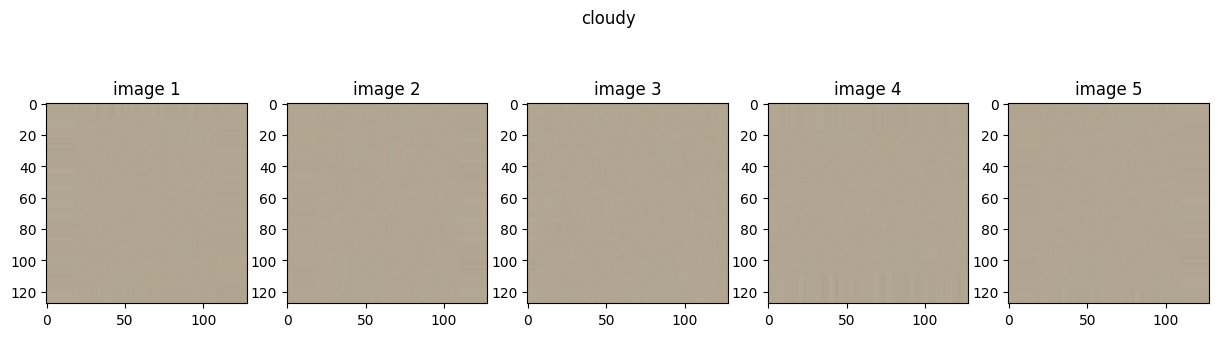

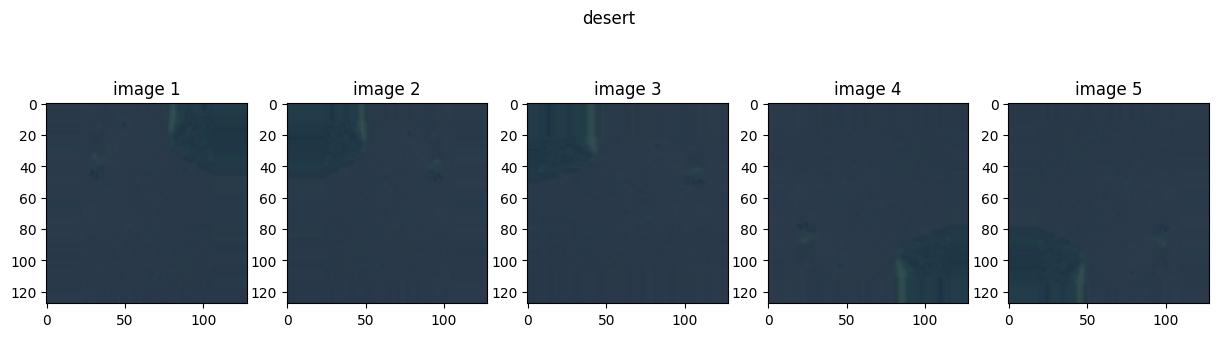

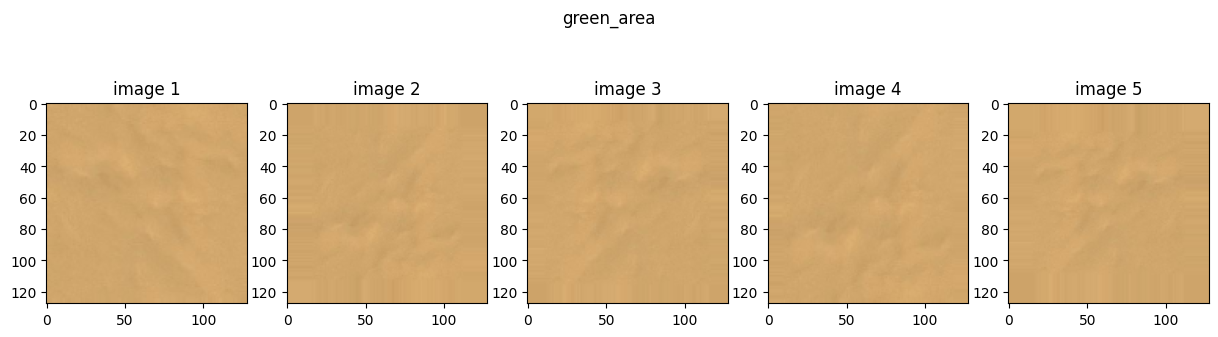

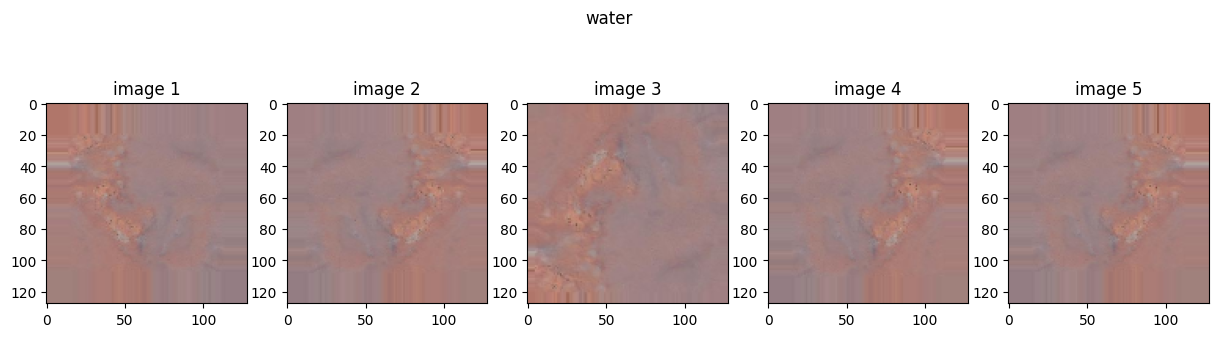

In [42]:
# plot 5 augmented images per class
show_subplot_img(5, (15, 4), img_gen_rgbs_dict)

In [43]:
img_test = test_img_datagen.flow_from_dataframe(
    img_test_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9, 
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=False
)

Found 281 validated image filenames belonging to 4 classes.


- Number of images for training, validation, and test are 4,548; 802; and 281 respectively

# Modelling

In [44]:
# define path const for saving model history
HIST_MODEL_DIR_PATH = path_join("/kaggle/working", "hist_model")
SAVED_HIST_MODEL_DIR_PATH = "/kaggle/input/model-history-images"

In [45]:
def get_model_history(
    model: object,
    loss_function: object,
    optimizer: object,
    metrics: list,
    train_data: DataFrameIterator,
    val_data: DataFrameIterator,
    epochs: int,
    callbacks: list=None
):
    """
    Get history model in dataframe form.

    This function process end-to-end :model in the following steps:
    1. compile
    2. fitting
    
    :param model (object) -> model object that hasn't been fitted
    :param loss_function (object) -> loss function used when compiling the :model
    :param optimizer (object) -> optimezer function used when compiling the :model
    :param metrics (list) -> list of evaluation metrics
    :param train_data (DataFrameIterator) -> data train from DataImageGenerator
    :param val_data (DataFrameIterator) -> data validation from DataImageGenerator
    :param epoches (int) -> number of epochs for :model fitting
    :param callbacks (list, default=None) -> list of callback function to call in model fitting process

    :return fitted history of the :model (pd.DataFrame)
    """

    model.compile(
        loss=loss_function, 
        optimizer=optimizer, 
        metrics=metrics
    )

    history = model.fit(
        train_data, 
        epochs=epochs, 
        validation_data=val_data, 
        verbose=1,
        callbacks=callbacks
    )

    return pd.DataFrame(history.history)

In [46]:
def create_dir_if_not_exists(dir_path: str)->None:
    """
    Create a new directory if it's not exist
    
    :param dir_path (str) -> path of the directory
    
    :return None
    """
    
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [47]:
def plot_model_history(df: pd.DataFrame, model_name: str):
    """
    Plot model training history to show accuracy and loss
    Then save each figures into directory using `save_fig` function

    :param df (pd.DataFrame) -> data source that contains accuracy and loss on train and val data

    :return None
    """

    # plot accuracy on train and val set
    df[["accuracy", "val_accuracy"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy on Train and Val data")
    plt.show()
    
    # plot loss on train and val set
    df[["loss", "val_loss"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss on Train and Val data")
    plt.show()

In [48]:
def save_model_history_df(df: pd.DataFrame, model_name: str)->None:
    """
    Save model's training history as df
    
    :param df (pd.DataFrame) -> model's training history to save
    ;param model_name (str) -> model's name
    
    :return None
    """
    
    MODEL_DIR_PATH = path_join(HIST_MODEL_DIR_PATH, model_name)
    
    create_dir_if_not_exists(MODEL_DIR_PATH)
    
    df.to_csv(
        path_join(MODEL_DIR_PATH, f"{model_name}-train_hist.csv"), 
        index=False
    )



def load_model_history_df(hist_file_path: str)->pd.DataFrame:
    """
    Load model's training history as df from :hist_file_path
    
    ;param hist_file_path (str) -> file path of model's history dataframe
    
    :return pd.DataFrame -> model's training history
    """
    
    return pd.read_csv(hist_file_path)

In [49]:
def save_model_evaluation(model: object, test_data: DataFrameIterator)->None:
    """
    Show :model evaluation on unseen data (:test_data)
    
    :param model -> fitted model
    :param test_data -> data that contains image from image generator
    
    :return None
    """
    preds = model.predict(test_data)
    preds = np.argmax(preds, axis=1)
    
    MODEL_DIR_PATH = path_join(HIST_MODEL_DIR_PATH, model.name)
    
    create_dir_if_not_exists(MODEL_DIR_PATH)
    
    accuracy_res = accuracy_score(test_data.classes, preds)
    
    json.dump(
        accuracy_res,
        open(path_join(MODEL_DIR_PATH, f"{model.name}-accuracy.json"), "w")
    )
    

def load_model_evaluation(accuracy_score_file_path: str)->float:
    """
    Load model's evaluation score from :accuracy_score_file_path
    
    :param accuracy_score_file_path (str) -> path of model's accuracy file
    
    :return model's evaluation score (float)
    """
    
    return round(float(
            json.load(open(accuracy_score_file_path, "r"))
        ), 4)

## Model 1

### Training

For the first model, I will try this configurations:
- layers:
    - convolution2d
        - filter: 128
        - activation: relu
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
    - avg pooling 2d
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - padding: same -> mantaining pixel on each image's edges, since some images are having important object for differentiate image's characteristics on some edges
    - convolution 2d
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - filter: 258
        - activation: relu
    - flatten -> convert multidimensional data into one dimensional data, so it can be feeded to dense layer
    - dense
        - activation: relu
        - units: 512
    - dense (output)
        - activation: softmax -> for multi class classification
        - units: 4 -> to identify 4 classes
- optimizer: adam
- metrics: accuracy -> stated in objective
- epochs: 30 -> try high epoch to get the best result, since I implemented early stopping
- callback: early stopping
    - patience: 10 -> high patience so that the model won't miss global optima
    - monitor: val accuracy
    - mode: max -> stop the training process if the accuracy on validation data hasn't increasing by 10 tries
- loss function: categorical crossentrophy -> for multi class classification

- The value of filter and units on convolution and dense layer are increasing to get better result on accuracy [reference](https://www.quora.com/How-does-increasing-filter-size-improve-the-accuracy-of-a-convolutional-neural-network-CNN#:~:text=Increasing%20the%20filter%20size%20in,make%20predictions%20about%20the%20data.)

In [50]:
model1 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model1")

model1.summary()

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# %%time
# history1 = get_model_history(
#     model1,
#     "categorical_crossentropy",
#     tf.keras.optimizers.Adam(learning_rate=0.001),
#     ["accuracy"],
#     img_train,
#     img_val,
#     30,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             patience=10,
#             monitor='val_accuracy',
#             mode="max"
#         )
#     ]
# )

# history1

In [52]:
# save_model_history_df(history1, model1.name)

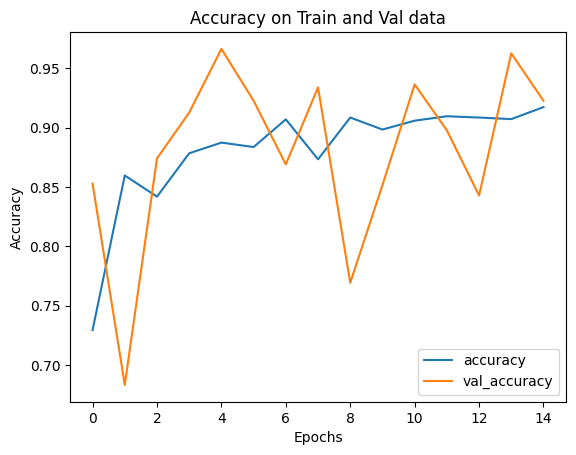

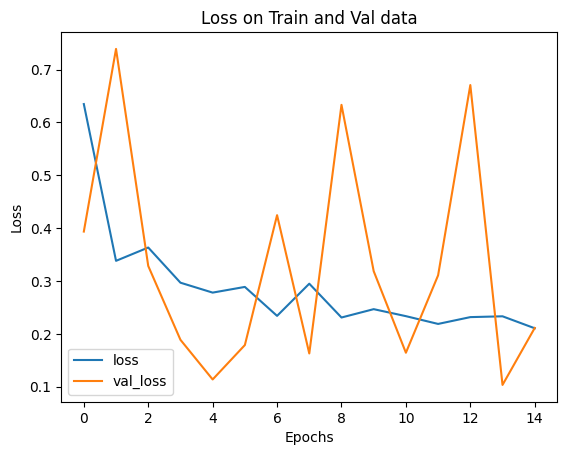

In [53]:
# load model1's saved training history dataframe
plot_model_history(
    load_model_history_df(path_join(SAVED_HIST_MODEL_DIR_PATH, "model1-train_hist.csv")), 
    "model1"
)

In [54]:
# read last row of model1's training history
pd.read_csv(path_join(SAVED_HIST_MODEL_DIR_PATH, "model1-train_hist.csv")).tail(1)

,accuracy,loss,val_accuracy,val_loss
14,0.917326,0.210598,0.922693,0.211227


### Evaluation

In [55]:
# save model1's accuracy score
# save_model_evaluation(model1, img_test)

In [56]:
# load saved model1's accuracy score
load_model_evaluation(path_join(SAVED_HIST_MODEL_DIR_PATH, "model1-accuracy.json"))

0.8754

- The first model was able to generate 91%, 92%, 87,5% accuracy on train, validation, and test data respectively, but accuracy on test set is 87,5%. 
- Thus, this model can be considered as good fit, since the difference of accuracy score on test and train data is +- 3,5%.
- But the training history plot shows that the model's accuracy and loss have many spikes, indicating that the model has an exploding gradient problem

## Model Tuned

### Training

The first model was able to generate good accuracy score 87,5%, thus in the tuned model I'll just increase the filter and units size on covolution and dense layer to generate even higher accuracy:
- layers:
    - convolution2d
        - filter: 256
        - activation: relu
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
    - avg pooling 2d
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - padding: same -> mantaining pixel on each image's edges, since some images are having important object for differentiate image's characteristics on some edges
    - convolution 2d
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - filter: 512
        - activation: relu
    - flatten -> convert multidimensional data into one dimensional data, so it can be feeded to dense layer
    - dense
        - activation: relu
        - units: 1024
    - dense (output)
        - activation: softmax -> for multi class classification
        - units: 4 -> to identify 4 classes
- optimizer: adam
- metrics: accuracy -> stated in objective
- epochs: 30 -> try high epoch to get the best result, since I implemented early stopping
- callback: early stopping
    - patience: 10 -> high patience so that the model won't miss global optima
    - monitor: val accuracy
    - mode: max -> stop the training process if the accuracy on validation data hasn't increasing by 10 tries
- loss function: categorical crossentrophy -> for multi class classification

- The value of filter and units on convolution and dense layer are increasing to get better result on accuracy [reference](https://www.quora.com/How-does-increasing-filter-size-improve-the-accuracy-of-a-convolutional-neural-network-CNN#:~:text=Increasing%20the%20filter%20size%20in,make%20predictions%20about%20the%20data.)

In [57]:
model_tuned = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=512,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        1024,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model-tuned")

model_tuned.summary()

Model: "model-tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 32, 32, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │   134,218,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,750,980 (514.03 MB)

 Trainable params: 134,750,980 (514.03 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# %%time
# history_model_tuned = get_model_history(
#     model_tuned,
#     "categorical_crossentropy",
#     tf.keras.optimizers.Adam(learning_rate=0.0001),
#     ["accuracy"],
#     img_train,
#     img_val,
#     30,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             patience=10,
#             monitor='val_accuracy',
#             mode="max"
#         )
#     ]
# )

# history_model_tuned

In [59]:
# save model_tuned's training history
# save_model_history_df(history_model_tuned, model_tuned.name)

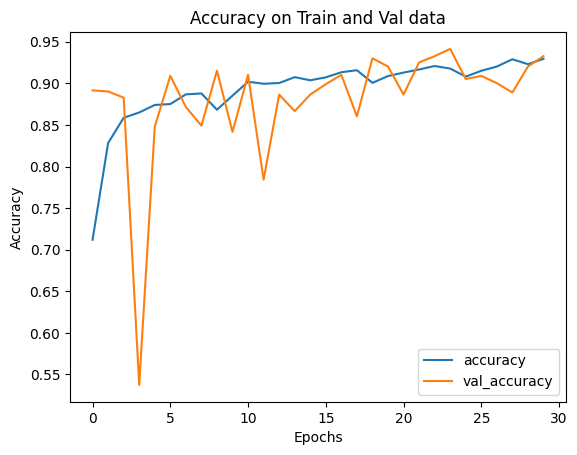

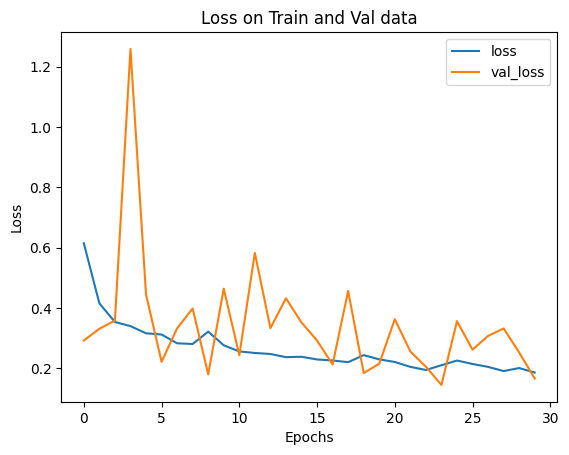

In [60]:
# load model_tuned's saved training history dataframe
plot_model_history(
    load_model_history_df(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned-train_hist.csv")),
    "model-tuned"
)

In [61]:
pd.read_csv(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned-train_hist.csv")).tail(1)

,accuracy,loss,val_accuracy,val_loss
29,0.92942,0.185396,0.932668,0.16582


### Evaluation

In [62]:
# save_model_evaluation(model_tuned, img_test)

In [63]:
# load saved model_tuned's accuracy score
load_model_evaluation(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned-accuracy.json"))

0.9004

- The tuned model was able to generate 92%, 93%, and 90% accuracy on train, validation, and test data respectively.
- This model also good fit, since the difference of accuracy score on test and train data is +- 2%.
- The tuned model is an improved version of the first model because it generates higher accuracy on both the training and validation data. Additionally, this model also reduced the score difference between the training and test data, proving that it is more consistent and robust

- But this model still has exploding gradient problem

# Model misclassification analysis

In [64]:
img_test_df["label"].value_counts()

label
cloudy        75
green_area    75
water         75
desert        56
Name: count, dtype: int64

In [65]:
# load saved model
loaded_model = tf.keras.models.load_model(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned.keras"))

pred_res = loaded_model.predict(img_test)
pred_res = np.argmax(pred_res, axis=1)
pred_res

I0000 00:00:1725986302.764689    1019 service.cc:145] XLA service 0x797c8c007ea0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725986302.764793    1019 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1725986302.897324    1019 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [66]:
# create a dataframe to contain true and pred label
img_test_analysis = pd.DataFrame()
img_test_analysis["true_label"] = img_test.classes
img_test_analysis["pred_label"] = pred_res

In [67]:
img_test_analysis

,true_label,pred_label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
276,3,3
277,3,3
278,3,3
279,3,3


In [68]:
# filter miss-classified images
miss_pred_df = img_test_analysis[
    img_test_analysis["true_label"]!=img_test_analysis["pred_label"]
]
miss_pred_df

,true_label,pred_label
5,0,1
32,0,1
42,0,1
47,0,1
61,0,3
85,1,0
117,1,0
129,1,0
139,2,3
142,2,3


In [69]:
img_test.class_indices

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

In [70]:
# filter image that miss-classifed as cloudy
miss_classified_as_cloudy = miss_pred_df[miss_pred_df["pred_label"]==0]
miss_classified_as_cloudy

,true_label,pred_label
85,1,0
117,1,0
129,1,0
224,3,0


In [71]:
# filter image that miss-classifed as cloudy
miss_classified_as_cloudy = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==0].index]
miss_classified_as_cloudy

,label,path
1815,desert,/kaggle/input/satellite-image-classification/d...
2076,desert,/kaggle/input/satellite-image-classification/d...
1702,desert,/kaggle/input/satellite-image-classification/d...
4495,water,/kaggle/input/satellite-image-classification/d...


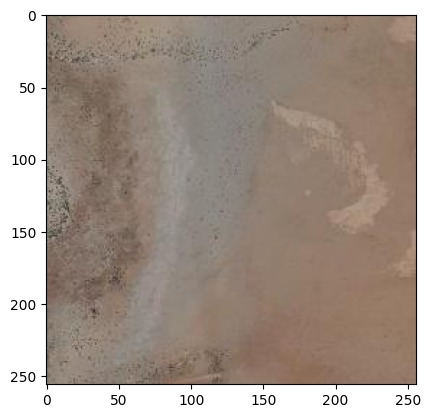

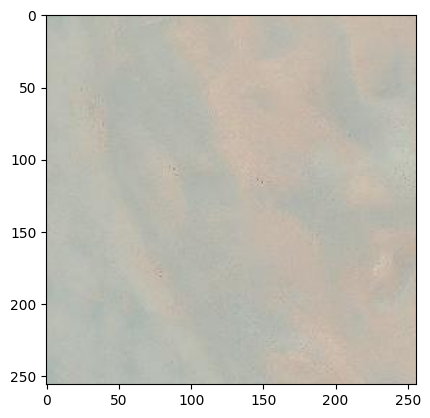

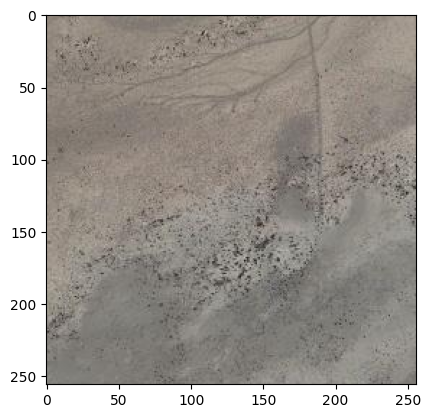

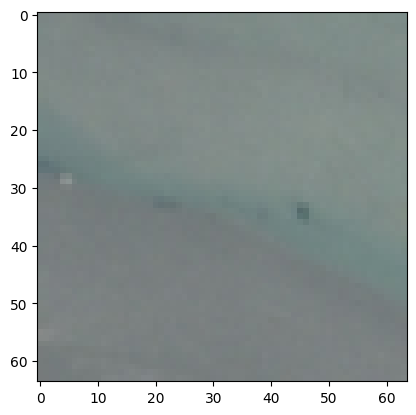

In [72]:
# plot image that miss-classifed as cloudy
for path in miss_classified_as_cloudy["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- It turns out that all the images that the model misclassified as cloudy are similar to actual cloudy images
- These images are all having greyish color, except for the first one

In [73]:
# filter image that miss-classifed as desert
miss_classified_as_desert = miss_pred_df[miss_pred_df["pred_label"]==1]
miss_classified_as_desert

,true_label,pred_label
5,0,1
32,0,1
42,0,1
47,0,1


In [74]:
# filter image that miss-classifed as desert
miss_classified_as_desert = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==1].index]
miss_classified_as_desert

,label,path
1157,cloudy,/kaggle/input/satellite-image-classification/d...
1135,cloudy,/kaggle/input/satellite-image-classification/d...
1493,cloudy,/kaggle/input/satellite-image-classification/d...
708,cloudy,/kaggle/input/satellite-image-classification/d...


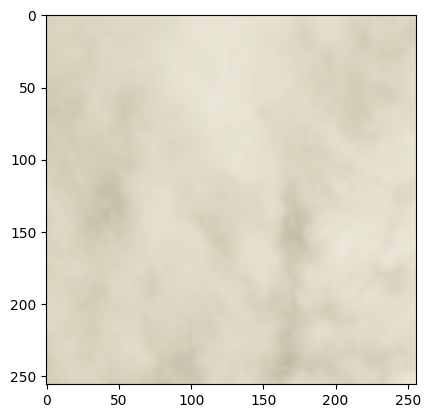

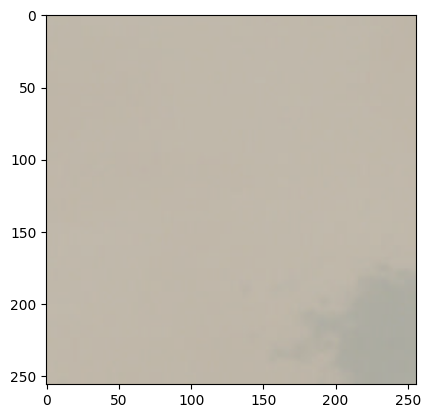

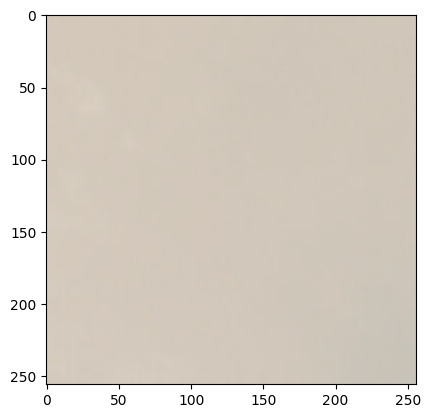

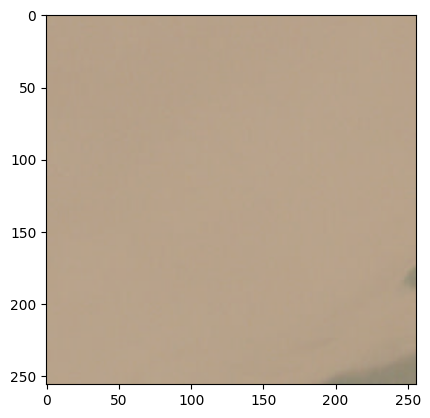

In [75]:
# plot image that miss-classifed as desert
for path in miss_classified_as_desert["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- All images that the model misclassified as desert are similar to actual desert images
- These images are all having brownish color

- This conclude that some cloudy and desert images in the dataset are having similar colors.
- It might be that there's not enough cloudy image that similar to desert and vice versa in the dataset, so the model is uncorrectly identify these images' characteristics

In [76]:
# filter image that miss-classifed as green area
miss_classified_as_green_area = miss_pred_df[miss_pred_df["pred_label"]==2]
miss_classified_as_green_area

,true_label,pred_label
210,3,2
213,3,2
223,3,2
230,3,2
234,3,2
235,3,2
260,3,2
261,3,2
262,3,2
268,3,2


In [77]:
# filter image that miss-classifed as green area
miss_classified_as_green_area = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==2].index]
miss_classified_as_green_area

,label,path
5542,water,/kaggle/input/satellite-image-classification/d...
4306,water,/kaggle/input/satellite-image-classification/d...
5552,water,/kaggle/input/satellite-image-classification/d...
5251,water,/kaggle/input/satellite-image-classification/d...
5046,water,/kaggle/input/satellite-image-classification/d...
5390,water,/kaggle/input/satellite-image-classification/d...
4667,water,/kaggle/input/satellite-image-classification/d...
5444,water,/kaggle/input/satellite-image-classification/d...
4844,water,/kaggle/input/satellite-image-classification/d...
5186,water,/kaggle/input/satellite-image-classification/d...


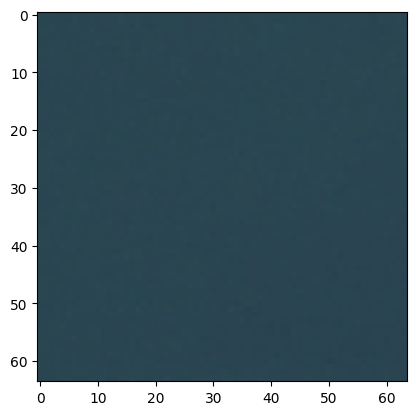

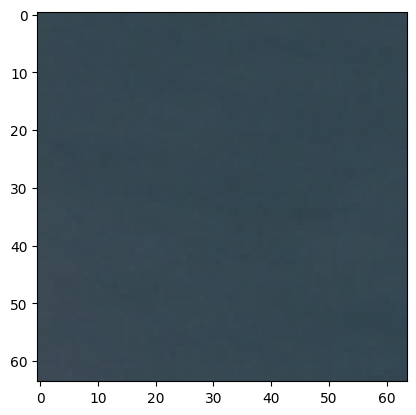

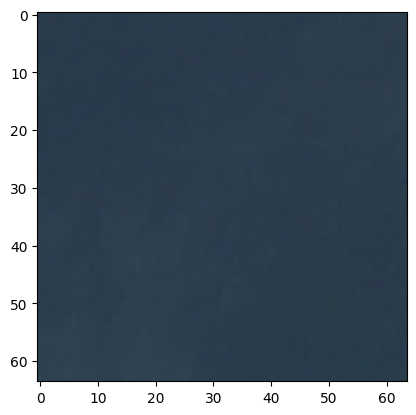

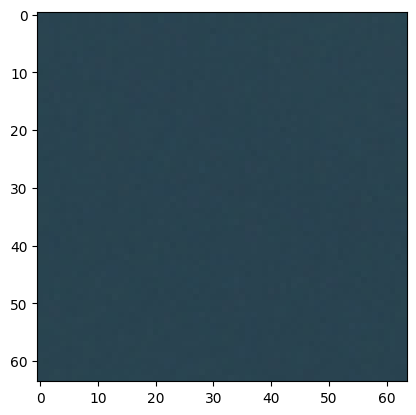

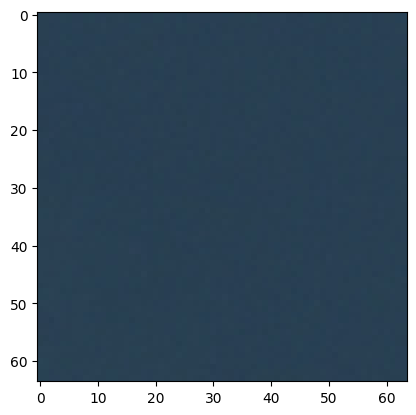

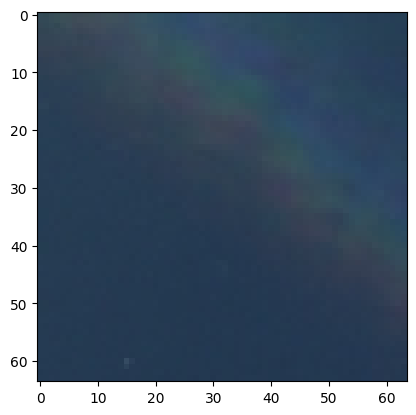

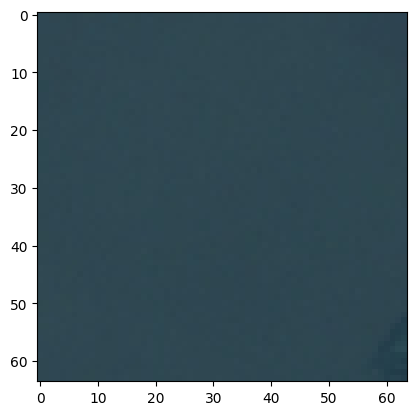

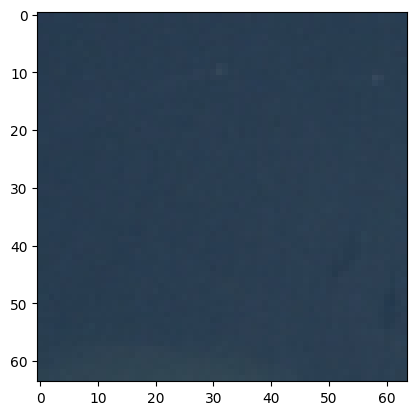

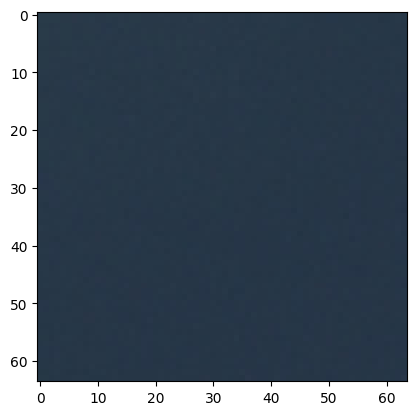

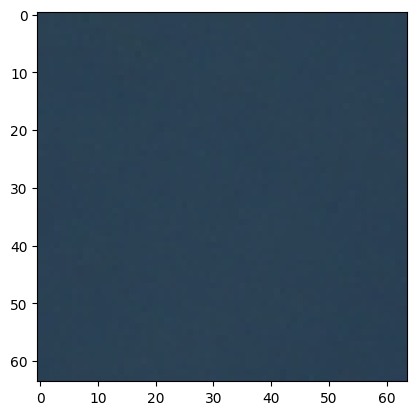

In [78]:
# plot image that miss-classifed as green area
for path in miss_classified_as_green_area["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- All images that the model misclassified as green area are having mixed green and blue colors

In [79]:
# filter image that miss-classifed as water
miss_classified_as_water = miss_pred_df[miss_pred_df["pred_label"]==3]
miss_classified_as_water

,true_label,pred_label
61,0,3
139,2,3
142,2,3
151,2,3
152,2,3
165,2,3
174,2,3
178,2,3
181,2,3
197,2,3


In [80]:
# filter image that miss-classifed as water
miss_classified_as_water = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==3].index]
miss_classified_as_water

,label,path
66,cloudy,/kaggle/input/satellite-image-classification/d...
2891,green_area,/kaggle/input/satellite-image-classification/d...
3887,green_area,/kaggle/input/satellite-image-classification/d...
2813,green_area,/kaggle/input/satellite-image-classification/d...
3277,green_area,/kaggle/input/satellite-image-classification/d...
3736,green_area,/kaggle/input/satellite-image-classification/d...
3296,green_area,/kaggle/input/satellite-image-classification/d...
3339,green_area,/kaggle/input/satellite-image-classification/d...
3424,green_area,/kaggle/input/satellite-image-classification/d...
3144,green_area,/kaggle/input/satellite-image-classification/d...


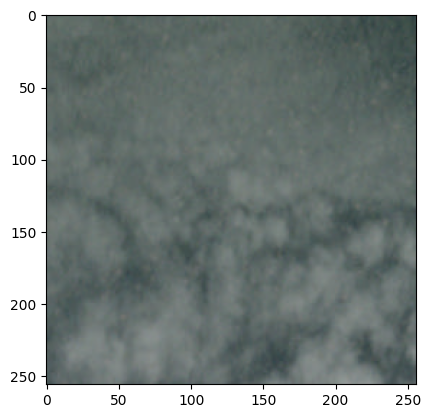

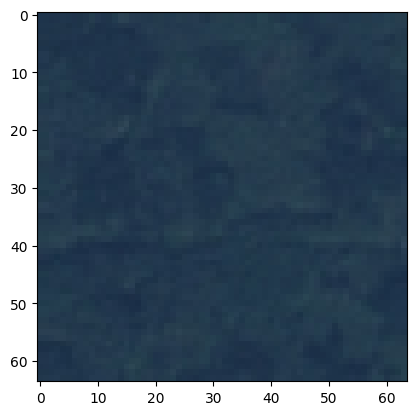

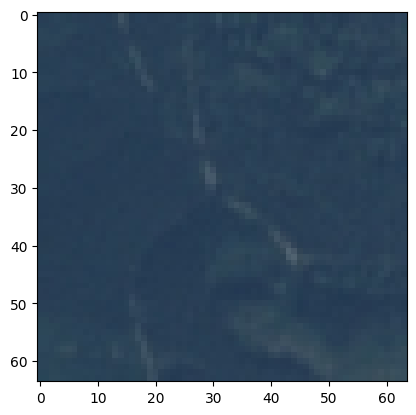

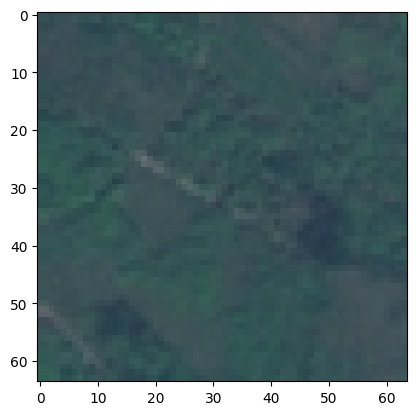

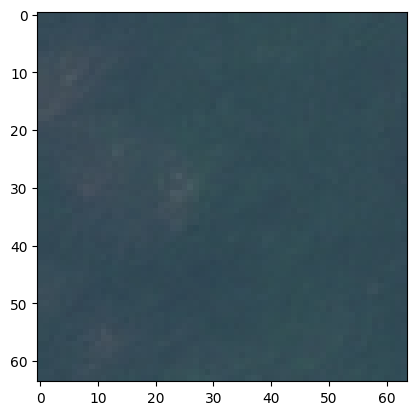

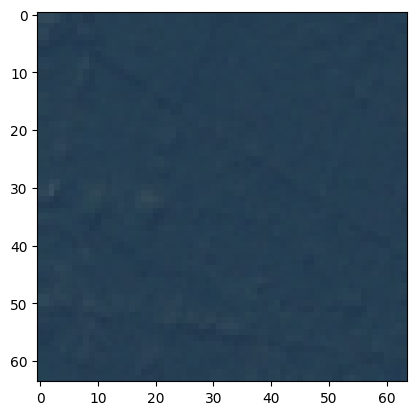

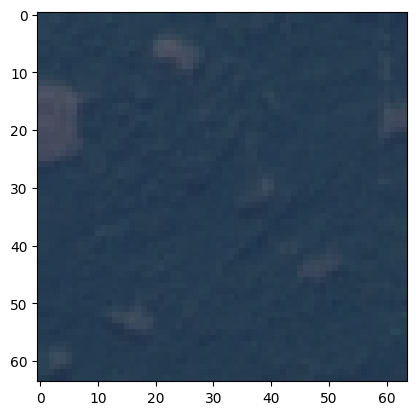

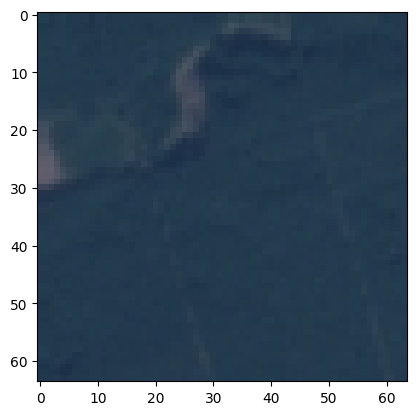

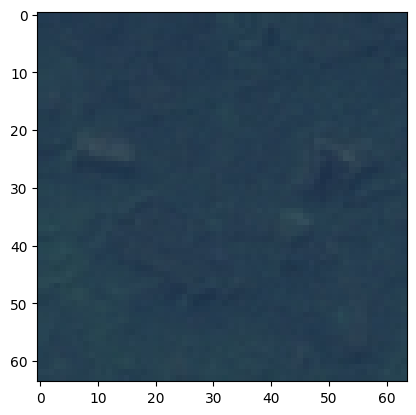

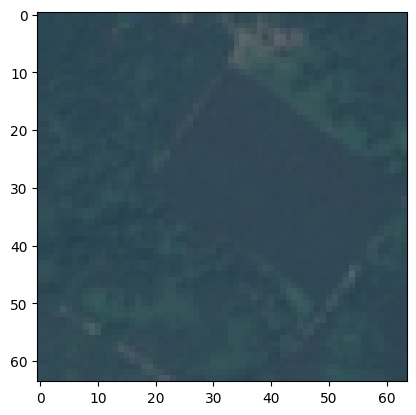

In [81]:
# plot image that miss-classifed as water
for path in miss_classified_as_water["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- All images that the model misclassified as water are having mixed green and blue colors, except the first one

- This conclude that, some green area and water images in the dataset are having mixed green and blue color.
- This misclassification also occurred because there are not enough water images similar to green areas, and vice versa, in the dataset

# Conclusion

- Tuned model is the best model to be used in NASA's system since it produced 90% accuracy and meets the minimum accuracy requirement stated in objective
- 90% accuracy means that `out of 10 images for every classes(cloudy, green area, desert, and water), this model able to correctly classify 9 of them`

Further improvement:
- Despite this model able to meet the minimum requirement on accuracy score, the model's size is exceptionally. As stated in [this reference](https://www.linkedin.com/pulse/your-model-slow-vijay-raghavan-ph-d-m-b-a-/), larger model tends to inference slower.

- The model can be improved by decreasing the number of units in the dense layers and the filter size in the convolution layers respectively, this will make the model's size to decrease. But the model's accuracy on the training, validation, and test data must remain similar, if not the same.

- The model also has some pattern in terms of misclassifying images, such as:
    - some water images misclassified as green area, and vice versa
    - some cloudy images misclassified as desert, and vice versa
- To encounter this problem, the dataset must be improved by:
    - providing water images that similar to green area, and vice versa.
    - providing cloudy images that similar to desert, and vice versa.

# Save files

In [82]:
# for layer in model1.layers:
#     layer.trainable = False

In [83]:
# model_tuned.save(path_join(HIST_MODEL_DIR_PATH, "model-tuned", "model-tuned.keras"))

In [84]:
img_train.class_indices

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

In [85]:
# export class encoder mapping
# json.dump(
#     img_train.class_indices, 
#     open(
#         path_join("/kaggle/working/", "class_indices.json"),
#         "w"
#     )
# )